In [145]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm


# 1. Read CSV
df = pd.read_csv("Combined_IT_Data_3FY.csv")
df = df.rename(columns={"or": "op_rev"})

# 3. Apply simple filters
df = df[df["net_worth"] > 0]  
df = df[df["persistent_loss"] == 0]  
df = df[df["op_rev"].between(1, 20000)]                       # OR >= 1
df = df[df["pli"].between(-1, 50)]
#df = df[df["export_income_pct"] >= 75]        # export >= 75
df = df[df["emp_cost_pct"] >= 25]             # emp cost >= 25
df = df[df["service_income_pct"] >= 75]  


df.shape


(3992, 15)

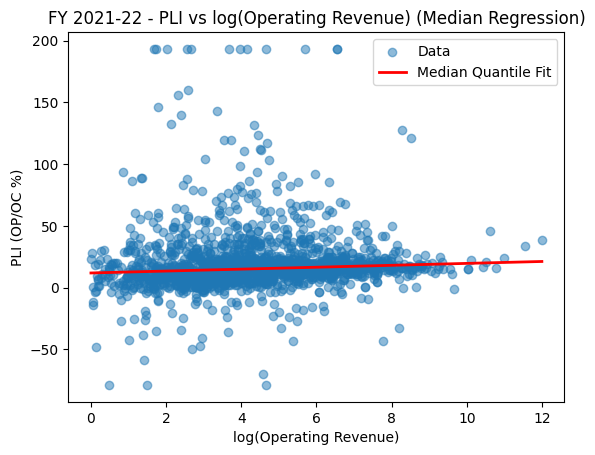

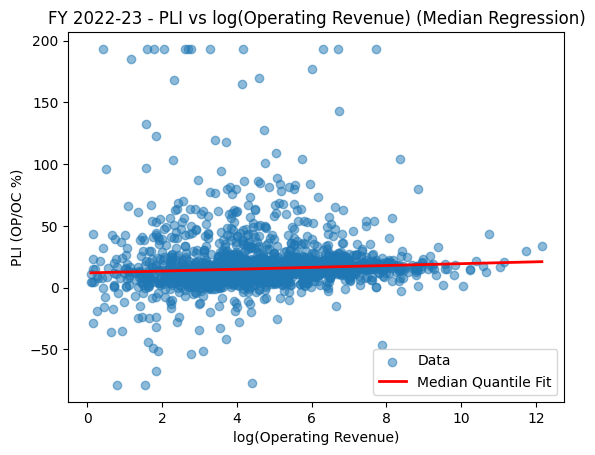

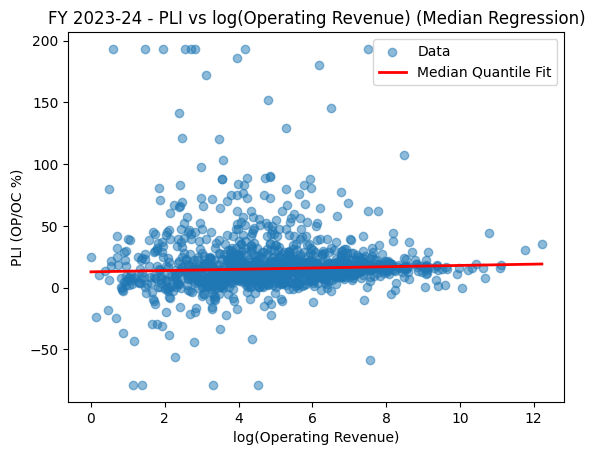

        FY  N_obs  Median_PLI  Intercept  Log_OR_Coeff    Slope_pval  \
0  2021-22   1650      15.900  11.914938      0.775797  1.135721e-09   
1  2022-23   1582      16.015  11.953820      0.749669  6.662930e-09   
2  2023-24   1350      15.885  12.827410      0.519096  1.869443e-05   

   Pseudo_R2  
0   0.008886  
1   0.009611  
2   0.004740  


In [95]:
df["log_op_rev"] = np.log(df["op_rev"])

results = []

# Loop over FY
for fy, sub in df.groupby("FY"):
    if sub.empty:
        continue

    # Prepare y and X (y = pli, X = log(OR))
    y = sub["pli"].values
    X = sm.add_constant(sub[["log_op_rev"]])

    # Median quantile regression
    model = sm.QuantReg(y, X)
    res = model.fit(q=0.5, max_iter=5000)

    # Save results with p-value + datapoints + median
    results.append({
        "FY": fy,
        "N_obs": len(sub),
        "Median_PLI": np.median(y),
        "Intercept": res.params["const"],
        "Log_OR_Coeff": res.params["log_op_rev"],
        "Slope_pval": res.pvalues["log_op_rev"],
        "Pseudo_R2": res.prsquared
    })

    # Scatter + regression line
    plt.scatter(sub["log_op_rev"], sub["pli"], alpha=0.5, label="Data")
    x_range = np.linspace(sub["log_op_rev"].min(), sub["log_op_rev"].max(), 100)
    X_pred = sm.add_constant(x_range)
    y_pred = res.predict(X_pred)
    plt.plot(x_range, y_pred, color="red", lw=2, label="Median Quantile Fit")
    plt.title(f"FY {fy} - PLI vs log(Operating Revenue) (Median Regression)")
    plt.xlabel("log(Operating Revenue)")
    plt.ylabel("PLI (OP/OC %)")
    plt.legend()
    plt.show()

# Results table
results_df = pd.DataFrame(results)
print(results_df)


In [116]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tools import add_constant

# Define buckets
buckets = [
    (0, 500, "0–500 Cr"),
    (500, float("inf"), ">500 Cr")
]

results = []

# Loop over FYs
for fy, df_fy in df.groupby("FY"):
    for lower, upper, label in buckets:
        df_bucket = df_fy[(df_fy["op_rev"] > lower) & (df_fy["op_rev"] <= upper)]
        
        if len(df_bucket) < 30:   # skip small samples
            continue
        
        y = df_bucket["pli"].values
        X_lin = add_constant(df_bucket["op_rev"])
        X_log = add_constant(np.log(df_bucket["op_rev"]))
        
        # Linear model
        mod_lin = sm.QuantReg(y, X_lin).fit(q=0.5, max_iter=1000)
        
        # Log model
        mod_log = sm.QuantReg(y, X_log).fit(q=0.5, max_iter=1000)
        
        results.append({
            "FY": fy,
            "Bucket": label,
            "N_obs": len(df_bucket),
            "Median_PLI": np.median(y),
            
            # Linear regression
            "Linear_Slope": mod_lin.params.iloc[1],
            "Linear_pval": mod_lin.pvalues.iloc[1],
            "Linear_PseudoR2": mod_lin.prsquared,
            
            # Log regression
            "Log_Slope": mod_log.params.iloc[1],
            "Log_pval": mod_log.pvalues.iloc[1],
            "Log_PseudoR2": mod_log.prsquared,
        })

results_df = pd.DataFrame(results)
print(results_df)



        FY    Bucket  N_obs  Median_PLI  Linear_Slope   Linear_pval  \
0  2021-22  0–500 Cr    549       16.21      0.003237  2.363149e-01   
1  2021-22   >500 Cr    243       17.37      0.000135  2.825913e-06   
2  2022-23  0–500 Cr    519       16.72      0.005400  7.242792e-02   
3  2022-23   >500 Cr    262       17.39      0.000087  4.863358e-05   
4  2023-24  0–500 Cr    419       17.01      0.003559  1.709784e-01   
5  2023-24   >500 Cr    272       16.74      0.000094  5.968552e-08   

   Linear_PseudoR2  Log_Slope  Log_pval  Log_PseudoR2  
0         0.001150   0.684259  0.004223      0.009292  
1         0.028460   0.253271  0.500540      0.000501  
2         0.006100   0.888974  0.001574      0.011995  
3         0.016726  -0.252918  0.424285      0.000335  
4         0.001979   0.415376  0.110837      0.000803  
5         0.018809   0.315464  0.229684      0.002810  


In [108]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools import add_constant

cutoffs = range(50, 2501, 10)   # 50Cr to 2500Cr in steps of 10
results_bucket1 = []
results_bucket2 = []

for c in cutoffs:
    # Split data
    df_low = df[df["op_rev"] <= c]
    df_high = df[df["op_rev"] > c]
    
    # Only run if enough data points in bucket
    if len(df_low) >= 30 and len(df_high) >= 30:
        
        # --- Bucket 1 (low OR) ---
        y1 = df_low["pli"].values
        X1 = add_constant(np.log(df_low["op_rev"]))
        mod1 = sm.QuantReg(y1, X1).fit(q=0.5, max_iter=1000)
        
        results_bucket1.append({
            "Cutoff": c,
            "N_obs": len(df_low),
            "Slope": mod1.params.iloc[1],
            "Pval": mod1.pvalues.iloc[1],
            "Pseudo_R2": mod1.prsquared
        })
        
        # --- Bucket 2 (high OR) ---
        y2 = df_high["pli"].values
        X2 = add_constant(np.log(df_high["op_rev"]))
        mod2 = sm.QuantReg(y2, X2).fit(q=0.5, max_iter=1000)
        
        results_bucket2.append({
            "Cutoff": c,
            "N_obs": len(df_high),
            "Slope": mod2.params.iloc[1],
            "Pval": mod2.pvalues.iloc[1],
            "Pseudo_R2": mod2.prsquared
        })

# Convert to DataFrames
bucket1_df = pd.DataFrame(results_bucket1)
bucket2_df = pd.DataFrame(results_bucket2)

print("\n--- Bucket 1 (OR ≤ cutoff) ---")
print(bucket1_df.head(10))

print("\n--- Bucket 2 (OR > cutoff) ---")
print(bucket2_df.head(10))


C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.


--- Bucket 1 (OR ≤ cutoff) ---
   Cutoff  N_obs     Slope      Pval  Pseudo_R2
0      50    552  0.563295  0.310090   0.001584
1      60    618  1.281784  0.009604   0.006192
2      70    685  1.373175  0.001526   0.008345
3      80    732  1.357587  0.000642   0.009139
4      90    777  1.231365  0.001096   0.007057
5     100    822  1.211439  0.000449   0.008145
6     110    854  0.992526  0.002123   0.007007
7     120    889  0.992524  0.001065   0.007946
8     130    929  0.946928  0.000889   0.007238
9     140    958  0.787150  0.003486   0.006160

--- Bucket 2 (OR > cutoff) ---
   Cutoff  N_obs     Slope      Pval     Pseudo_R2
0      50   1712 -0.061649  0.533044  1.079157e-04
1      60   1646 -0.003464  0.972718  6.058338e-07
2      70   1579  0.062632  0.549984  3.210970e-05
3      80   1532  0.095524  0.374534  9.636134e-05
4      90   1487 -0.005267  0.961440  1.845248e-06
5     100   1442 -0.000715  0.994934 -3.793951e-09
6     110   1410 -0.031391  0.783522  4.069752e-05


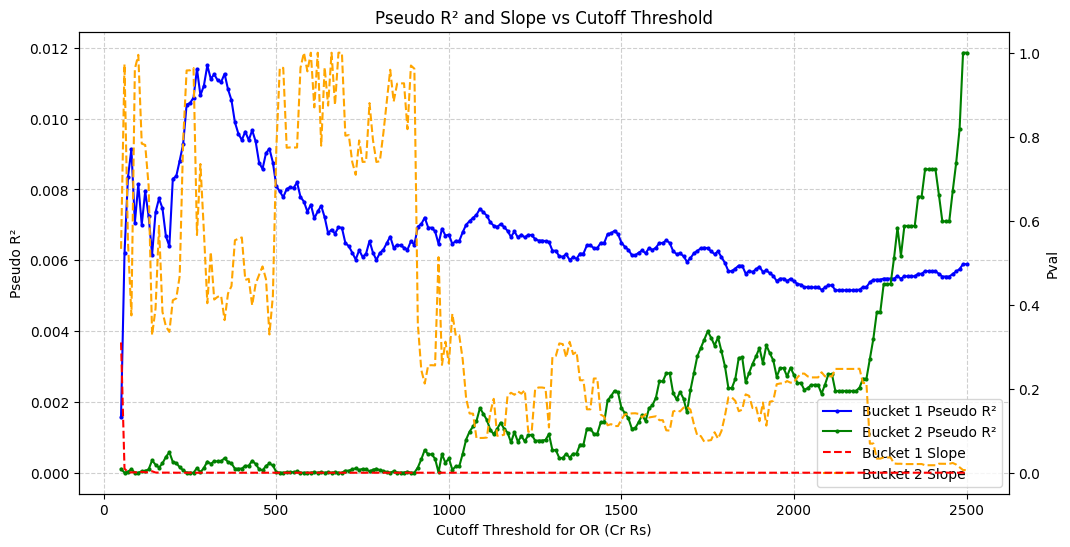

In [113]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot Pseudo R² for both buckets
ax1.plot(bucket1_df["Cutoff"], bucket1_df["Pseudo_R2"], label="Bucket 1 Pseudo R²", color="blue", marker="o", markersize=2)
ax1.plot(bucket2_df["Cutoff"], bucket2_df["Pseudo_R2"], label="Bucket 2 Pseudo R²", color="green", marker="o", markersize=2)
ax1.set_xlabel("Cutoff Threshold for OR (Cr Rs)")
ax1.set_ylabel("Pseudo R²")
ax1.grid(True, linestyle="--", alpha=0.6)

# Secondary axis for slopes
ax2 = ax1.twinx()
ax2.plot(bucket1_df["Cutoff"], bucket1_df["Pval"], label="Bucket 1 Slope", color="red", linestyle="--")
ax2.plot(bucket2_df["Cutoff"], bucket2_df["Pval"], label="Bucket 2 Slope", color="orange", linestyle="--")
ax2.set_ylabel("Pval")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

plt.title("Pseudo R² and Slope vs Cutoff Threshold")
plt.show()



In [110]:

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools import add_constant

cutoffs = range(50, 2501, 10)   # 50Cr to 2500Cr in steps of 10
results_bucket3 = []
results_bucket4 = []

for c in cutoffs:
    # Split data
    df_low = df[df["op_rev"] <= c]
    df_high = df[df["op_rev"] > c]
    
    # Only run if enough data points in bucket
    if len(df_low) >= 30 and len(df_high) >= 30:
        
        # --- Bucket 1 (low OR) ---
        y1 = df_low["pli"].values
        X1 = add_constant((df_low["op_rev"]))
        mod1 = sm.QuantReg(y1, X1).fit(q=0.5, max_iter=1000)
        
        results_bucket3.append({
            "Cutoff": c,
            "N_obs": len(df_low),
            "Slope": mod1.params.iloc[1],
            "Pval": mod1.pvalues.iloc[1],
            "Pseudo_R2": mod1.prsquared
        })
        
        # --- Bucket 2 (high OR) ---
        y2 = df_high["pli"].values
        X2 = add_constant((df_high["op_rev"]))
        mod2 = sm.QuantReg(y2, X2).fit(q=0.5, max_iter=1000)
        
        results_bucket4.append({
            "Cutoff": c,
            "N_obs": len(df_high),
            "Slope": mod2.params.iloc[1],
            "Pval": mod2.pvalues.iloc[1],
            "Pseudo_R2": mod2.prsquared
        })

# Convert to DataFrames
bucket3_df = pd.DataFrame(results_bucket3)
bucket4_df = pd.DataFrame(results_bucket4)

print("\n--- Bucket 1 (OR ≤ cutoff) ---")
print(bucket3_df.head(10))

print("\n--- Bucket 2 (OR > cutoff) ---")
print(bucket4_df.head(10))



C:\Users\Administrator\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



--- Bucket 1 (OR ≤ cutoff) ---
   Cutoff  N_obs     Slope      Pval  Pseudo_R2
0      50    552  0.037727  0.292107   0.002594
1      60    618  0.074909  0.007123   0.011100
2      70    685  0.068500  0.001434   0.012690
3      80    732  0.056986  0.001675   0.012066
4      90    777  0.048641  0.002102   0.008458
5     100    822  0.040222  0.002510   0.008883
6     110    854  0.032271  0.005734   0.006768
7     120    889  0.026144  0.010133   0.007375
8     130    929  0.024411  0.006004   0.006367
9     140    958  0.019131  0.015967   0.004500

--- Bucket 2 (OR > cutoff) ---
   Cutoff  N_obs     Slope          Pval  Pseudo_R2
0      50   1712  0.000091  2.302260e-11   0.006175
1      60   1646  0.000092  5.763819e-12   0.006975
2      70   1579  0.000092  3.087708e-12   0.007541
3      80   1532  0.000092  2.255860e-12   0.007898
4      90   1487  0.000092  1.122068e-12   0.008132
5     100   1442  0.000092  1.160902e-12   0.008433
6     110   1410  0.000092  7.756903e-13   0

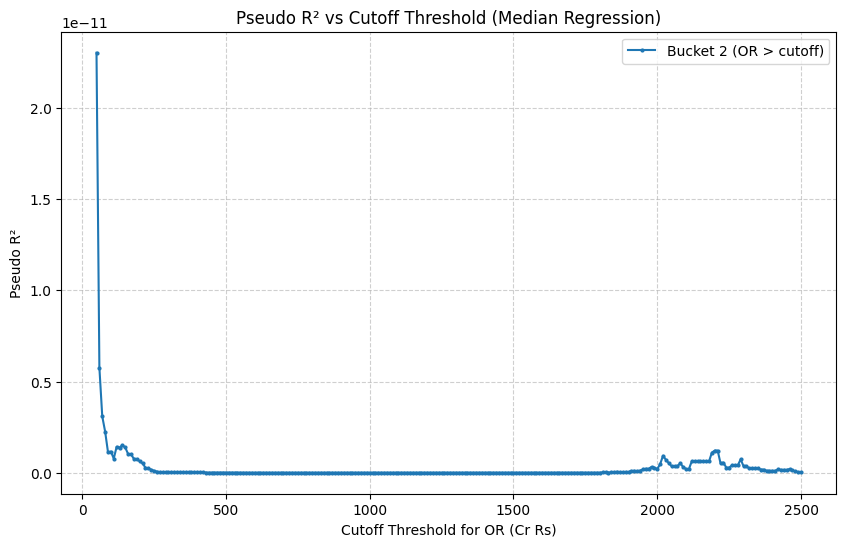

In [115]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot Pseudo-R² vs Cutoff for both buckets
#plt.plot(bucket3_df["Cutoff"], bucket3_df["Pval"], label="Bucket 1 (OR ≤ cutoff)", marker="o", markersize=2)
plt.plot(bucket4_df["Cutoff"], bucket4_df["Pval"], label="Bucket 2 (OR > cutoff)", marker="o", markersize=2)

plt.xlabel("Cutoff Threshold for OR (Cr Rs)")
plt.ylabel("Pseudo R²")
plt.title("Pseudo R² vs Cutoff Threshold (Median Regression)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()